In [10]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
import os
import xml.etree.ElementTree as ET
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [11]:
# Dataset Class
class VOCDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, image_ids, transforms=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_ids = [x for x in image_ids if self._validate_image(x)]  # Filter valid images
        self.transforms = transforms
        self.classes = ["__background__"] + [
            "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", 
            "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", 
            "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
        ]

    def _validate_image(self, img_id):
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        return os.path.exists(img_path) and cv2.imread(img_path) is not None

    def parse_annotation(self, xml_file):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        boxes, labels = [], []
        
        for obj in root.findall("object"):
            label = obj.find("name").text
            if label not in self.classes:
                continue
            bbox = obj.find("bndbox")
            boxes.append([
                int(bbox.find("xmin").text),
                int(bbox.find("ymin").text),
                int(bbox.find("xmax").text),
                int(bbox.find("ymax").text)
            ])
            labels.append(self.classes.index(label))
        
        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{image_id}.jpg")
        xml_path = os.path.join(self.annotation_dir, f"{image_id}.xml")

        image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        
        boxes, labels = self.parse_annotation(xml_path)
        return image, {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

    def __len__(self):
        return len(self.image_ids)

In [12]:
# Data Loader
def get_data_loaders(image_dir, annotation_dir, split_dir, batch_size=4):
    # Read all IDs from trainval.txt
    with open(os.path.join(split_dir, "trainval.txt"), "r") as f:
        all_ids = [line.strip() for line in f.readlines()]
    
    # Split into train (70%), val (20%), test (10%)
    train_ids, test_ids = train_test_split(all_ids, test_size=0.1, random_state=42)
    train_ids, val_ids = train_test_split(train_ids, test_size=0.222, random_state=42)  # 0.2/0.9 ≈ 0.222
    
    print(f"Dataset sizes - Train: {len(train_ids)}, Val: {len(val_ids)}, Test: {len(test_ids)}")
    
    # Create datasets
    train_dataset = VOCDataset(image_dir, annotation_dir, train_ids)
    val_dataset = VOCDataset(image_dir, annotation_dir, val_ids)
    test_dataset = VOCDataset(image_dir, annotation_dir, test_ids)
    
    # Create loaders
    def collate_fn(batch):
        return tuple(zip(*batch))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    return train_loader, val_loader, test_loader


In [13]:
# Model Definition (with transfer learning)
def get_model(num_classes, unfreeze_layers=5):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Freeze all layers first
    for param in model.parameters():
        param.requires_grad = False
        
    # Modify classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Unfreeze specified layers
    layers_to_unfreeze = [
        *list(model.backbone.fpn.parameters())[-unfreeze_layers:],
        *list(model.rpn.parameters())[-unfreeze_layers:],
        *list(model.roi_heads.parameters())
    ]
    for param in layers_to_unfreeze:
        param.requires_grad = True
        
    return model

In [14]:
# Save path
SAVE_PATH = "/kaggle/working/faster_rcnn.pth"
def train_model(model, train_loader, val_loader, num_epochs=1, lr=0.005):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Class weights (inverse frequency weighting)
    class_counts = {
    15: 3919, 7: 1159, 9: 1019, 16: 441, 3: 410, 5: 372, 12: 365, 2: 316, 4: 297,
    14: 292, 18: 280, 17: 277, 13: 273, 8: 266, 20: 250, 19: 228, 1: 224, 11: 220,
    10: 217, 6: 198
}
    total_samples = sum(class_counts.values())
    class_weights = torch.tensor([total_samples / count for count in class_counts.values()], 
                                dtype=torch.float32).to(device)
    class_weights = class_weights / class_weights.min()  # Normalize (optional)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass (loss computation happens inside model)
            loss_dict = model(images, targets)

            # Manually extract classification scores & apply weights
            # (This is a hack since torchvision doesn't expose per-class losses easily)
            # Instead, we modify the classifier weights before forward pass
            with torch.no_grad():
                old_weight = model.roi_heads.box_predictor.cls_score.weight.clone()
                model.roi_heads.box_predictor.cls_score.weight *= class_weights.unsqueeze(1)

            # Compute loss
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

            # Restore original weights (so we don't double-weight)
            with torch.no_grad():
                model.roi_heads.box_predictor.cls_score.weight.copy_(old_weight)

            if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}] | Batch [{batch_idx+1}/{len(train_loader)}] | Loss: {losses.item():.4f}")

    torch.save(model.state_dict(), SAVE_PATH)
            

In [15]:
# Define dataset paths
IMAGE_DIR = "/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/JPEGImages"
ANNOTATION_DIR = "/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/Annotations"
SPLIT_DIR = "/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/ImageSets/Main"

In [16]:
# Load dataset
train_loader, val_loader, test_loader = get_data_loaders(IMAGE_DIR, ANNOTATION_DIR, SPLIT_DIR)

Dataset sizes - Train: 3508, Val: 1001, Test: 502


In [17]:
# Load model
model = get_model(num_classes=21, unfreeze_layers=5)

In [ ]:

# Train model
train_model(model, train_loader, val_loader, num_epochs=3)

Epoch [1/1] | Batch [100/877] | Loss: 13.9950
Epoch [1/1] | Batch [200/877] | Loss: 112.3829
Epoch [1/1] | Batch [300/877] | Loss: 18.6029
Epoch [1/1] | Batch [400/877] | Loss: 10.8409
Epoch [1/1] | Batch [500/877] | Loss: 30.6227
Epoch [1/1] | Batch [600/877] | Loss: 120.4944
Epoch [1/1] | Batch [700/877] | Loss: 69.2353
Epoch [1/1] | Batch [800/877] | Loss: 80.1422
Epoch [1/1] | Batch [877/877] | Loss: 92.0124

Epoch [1/1] Completed | Total Loss: 92.0124

✅ Model saved at /kaggle/working/faster_rcnn.pth!


In [19]:
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve
from collections import defaultdict

In [22]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate model performance using mAP, precision, recall, and F1-score.
    """
    model.to(device)
    model.eval()

    pred_boxes, pred_labels, pred_scores = [], [], []
    gt_boxes, gt_labels = [], []

    with torch.no_grad():
        for images, targets in test_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes.append(output["boxes"].cpu().numpy())
                pred_labels.append(output["labels"].cpu().numpy())
                pred_scores.append(output["scores"].cpu().numpy())

                gt_boxes.append(target["boxes"].cpu().numpy())
                gt_labels.append(target["labels"].cpu().numpy())

    # Compute mAP and other metrics
    mAP_0_5, precision_list, recall_list, f1_list = compute_mAP(
        pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels
    )

    print(f"📊 Evaluation Results:")
    print(f"mAP @ IoU=0.5: {mAP_0_5:.4f}")
    print(f"Precision: {np.mean(precision_list):.4f}")
    print(f"Recall: {np.mean(recall_list):.4f}")
    print(f"F1-score: {np.mean(f1_list):.4f}")

    return mAP_0_5, precision_list, recall_list, f1_list

In [23]:
evaluate_model(model, test_loader, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

📊 Evaluation Results:
mAP @ IoU=0.5: 0.3428
Precision: 0.1181
Recall: 2.9504
F1-score: 0.1180


(0.34277612310961564,
 [0,
  0.0,
  0.0,
  0.1290322580640999,
  0,
  0.08784773060027996,
  0.33333333333055554,
  0.09566956931042486,
  0.11021685669572746,
  0.13750850918991575,
  0.499999999975,
  0.009852216748763621,
  0.10569249866997507,
  0.11506105834463731,
  0.11004315417810691,
  0.09431372549019423,
  0.23529411764567476,
  0.0,
  0.09090909090867769,
  0.0,
  0.32608695652103026],
 [0,
  0.0,
  0.0,
  0.06557377049169578,
  0,
  0.5555555555550411,
  0.11428571428538775,
  4.147959183671353,
  11.73809523806729,
  1.3648648648639428,
  0.02631578947361496,
  0.057142857142693876,
  9.933333333316778,
  9.860465116256139,
  22.439999999910242,
  1.1291079812203924,
  0.054794520547870144,
  0.0,
  0.04166666666657986,
  0.0,
  0.4285714285702041],
 [0,
  0.0,
  0.0,
  0.08695652169425805,
  0,
  0.1517067003556496,
  0.17021276591869622,
  0.18702553484721032,
  0.2183831672185237,
  0.2498453926858746,
  0.04999999999024999,
  0.016806722663975007,
  0.2091595016648683

In [24]:
def check_predictions(model, test_loader, threshold=0.5):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    images, targets = next(iter(test_loader))
    images = list(img.to(device) for img in images)

    with torch.no_grad():
        outputs = model(images)

    for i in range(len(images)):
        pred_scores = outputs[i]["scores"].cpu().numpy()
        pred_labels = outputs[i]["labels"].cpu().numpy()

        print(f"🔹 Image {i+1}:")
        print(f"  Predicted Labels: {pred_labels}")
        print(f"  Predicted Scores: {pred_scores}")

check_predictions(model, test_loader)


🔹 Image 1:
  Predicted Labels: [ 7 14  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7 12 12 12 12 12 12 12
 12 12 12 12 12 12 12 12 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13]
  Predicted Scores: [0.08201715 0.07853914 0.07195606 0.07195606 0.07195606 0.07195606
 0.07195606 0.07195606 0.07195606 0.07195606 0.07195606 0.07195606
 0.07195606 0.07195606 0.07195606 0.07195606 0.07195606 0.05687769
 0.05687769 0.05687769 0.05687769 0.05687769 0.05687769 0.05687769
 0.05687769 0.05687769 0.05687769 0.05687769 0.05687769 0.05687769
 0.05687769 0.05687769 0.05323654 0.05323654 0.05323654 0.05323654
 0.05323654 0.05323654 0.05323654 0.05323654 0.05323654 0.05323654
 0.05323654 0.05323654 0.05323654 0.05323654 0.05323654 0.05271111
 0.05271111 0.05271111 0.05271111 0.05271111 0.05271111 0.05271111
 0.05271111 0.05271111 0.05271111 0.05271111 0.05271111 0.05271111
 0.05271111 0.05271111 0.05116256 0.0511625

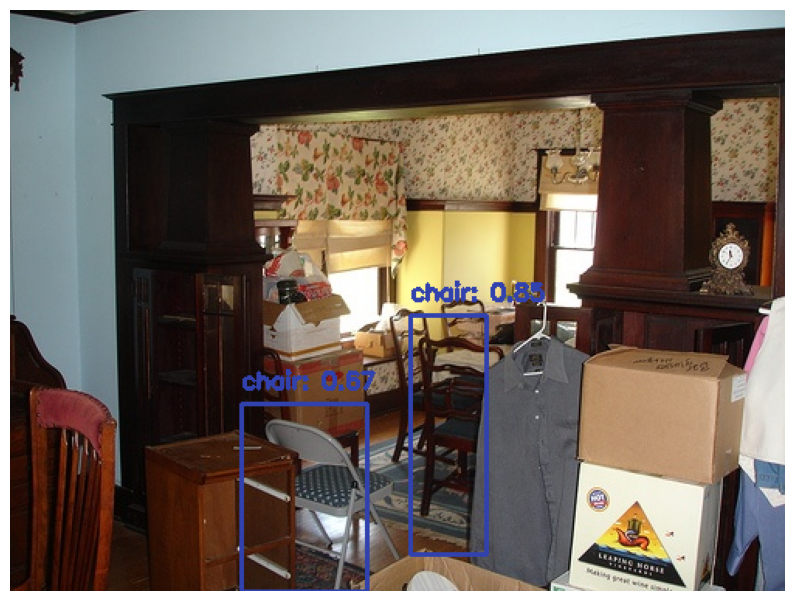

In [26]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load class names for VOC dataset
VOC_CLASSES = [
    "__background__", "aeroplane", "bicycle", "bird", "boat", "bottle",
    "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse",
    "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"
]

# Define colors for visualization
COLORS = np.random.uniform(0, 255, size=(len(VOC_CLASSES), 3))

def visualize_detections(model, image_path, threshold=0.5, device="cuda"):
    model.to(device)
    model.eval()
    
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = T.Compose([T.ToPILImage(), T.ToTensor()])
    image_tensor = transform(image_rgb).unsqueeze(0).to(device)
    
    # Run inference
    with torch.no_grad():
        predictions = model(image_tensor)[0]  # Get first image's predictions

    # Draw detections
    for box, label, score in zip(predictions["boxes"], predictions["labels"], predictions["scores"]):
        if score >= threshold:  # Apply confidence threshold
            x1, y1, x2, y2 = map(int, box.tolist())
            class_name = VOC_CLASSES[label]
            color = COLORS[label]

            # Draw bounding box
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put label & confidence score
            text = f"{class_name}: {score:.2f}"
            cv2.putText(image, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    # Show the image
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()


visualize_detections(model, "/kaggle/input/pascal-voc-2007-dataset/VOCdevkit2007/VOC2007/JPEGImages/000005.jpg", threshold=0.5)
